In [56]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd


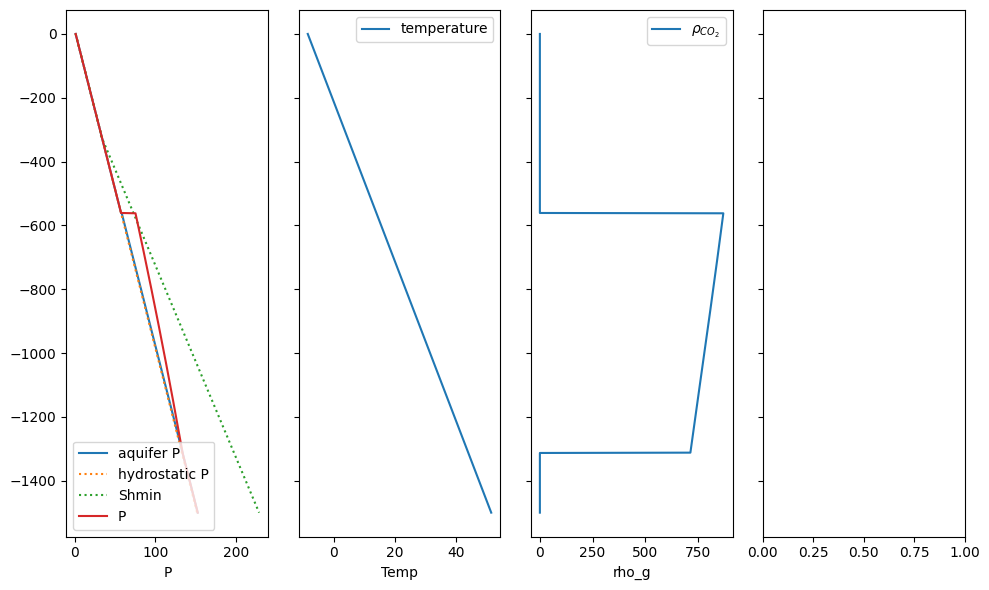

In [105]:
# atmospheric pressure
P_atm = 101325 / 1e5 # bar

# reservoir aquifer pressure
aq_P = 124 # bar

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top))
df = pd.DataFrame(data={'depth':z})


def P_aquifer(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_aq'] = P_aquifer(z=z, ref_P=aq_P, ref_Z=aq_Z)
df['P_hyd'] = P_atm-(df['depth']*rho_brine*G_acc)/1e5

df['Sh_min'] = df['P_hyd']
df.loc[df.depth<Z_sf, 'Sh_min'] = -(Z_sf*rho_brine*G_acc)/1e5 - 0.166*(df.loc[df.depth<Z_sf, 'depth']-Z_sf)

df


df.loc[df.depth>barrier_Z, 'P_aq'] =  df.loc[df.depth>barrier_Z, 'P_hyd']
df.loc[df.P_aq < P_atm, 'P_aq'] = P_atm

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]
Z_sf = -312 #seafloor depth [m]

df['Temp'] = T_sf - (df['depth']-Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_aquifer(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_aquifer(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_aq']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0
df['rho_g'] = 0





query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z = row.depth
    dz = row.dz
    T = row.Temp
    P_aq = row.P_aq

    if col_h == 0:
        P = P_aq
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

        df.loc[idx, 'rho_g'] = rho_g
        Pcap = 0
        P_previous = P
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5


        Pcap += dPcap

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap

        P = P_aq + Pcap



        df.loc[idx, 'P'] = P
        
        # rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

        if T < PropsSI('CO2', 'Tcrit')-273.15:
            pcrit = PropsSI('P','T',T+273.15,'Q',0,'CO2')

            # try:
            #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
            #     if rho_g >= 500:
            #         last_rho_g = rho_g
            #         print(z, P, pcrit/1e5,T, rho_g)
            #     else:
            #         rho_g = last_rho_g
            # except:
            #     rho_g = last_rho_g
            if np.abs((P*1e5/pcrit)-1) < 0.001:
                rho_g = PropsSI("D", "P", (P+5)*1e5, "T", T+273.15, "CO2")
                
            else:
                rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")

            # try:
            #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
            #     # if np.abs(rho_previous-rho_g)>100:
            #     #     print(z, P, pcrit/1e5,T, rho_g)
            # except:
            #     print(z, P, pcrit/1e5,T)

            # if np.abs((P*1e5/pcrit)-1) < 0.000001:
            #     print(z, P, pcrit/1e5,T, rho_g)

        else:
            rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, "CO2")
        # if np.abs(p*1e5 - pcrit)/pcrit > 1e-6:
        #     print(P, T)
        # try:    
        
        df.loc[idx, 'rho_g'] = rho_g

        rho_previous = rho_g
        
            

        # except:
        #     print(P,T)
        #     continue




fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(10, 6))

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P')
df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
df.plot(x='Sh_min', y='depth', ax= ax1, label='Shmin', linestyle=':')


df.plot(x='P', y='depth', ax= ax1, label='P')
# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')



# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])


# ax4.plot(PFT['sgas'], -PFT['depth'])


ax1.legend(loc='lower left')

fig.tight_layout()


In [101]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,dPcap,Pcap,rho_g
562,-562.0,1.013250,57.449632,72.83123,14.00,750.0,-1.0,54.295060,0.018203,53.281810,838.817576
563,-563.0,1.013250,57.550052,72.99723,14.04,749.0,-1.0,54.276857,0.018245,53.263607,838.386860
564,-564.0,1.013250,57.650473,73.16323,14.08,748.0,-1.0,54.258612,0.018287,53.245362,837.954814
565,-565.0,1.013250,57.750894,73.32923,14.12,747.0,-1.0,54.240325,0.018330,53.227075,837.521427
566,-566.0,1.013250,57.851314,73.49523,14.16,746.0,-1.0,54.221995,0.018373,53.208745,837.086686
...,...,...,...,...,...,...,...,...,...,...,...
1308,-1308.0,69.138275,132.363405,196.66723,43.84,4.0,-1.0,69.467949,0.082416,0.329673,183.611623
1309,-1309.0,69.238696,132.463826,196.83323,43.88,3.0,-1.0,69.485953,0.082418,0.247257,183.595436
1310,-1310.0,69.339117,132.564246,196.99923,43.92,2.0,-1.0,69.503956,0.082419,0.164840,183.579277
1311,-1311.0,69.439537,132.664667,197.16523,43.96,1.0,-1.0,69.521958,0.082421,0.082421,183.563147


In [102]:
PropsSI('P','T',14.04+273.15,'Q',0,'CO2')

4970577.5944873

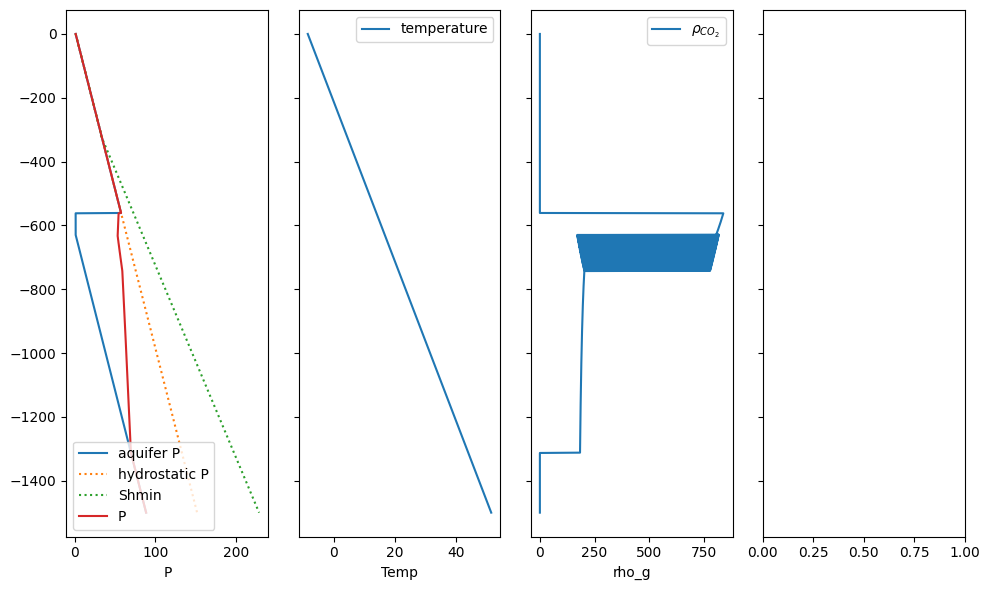

In [103]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(10, 6))

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P')
df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
df.plot(x='Sh_min', y='depth', ax= ax1, label='Shmin', linestyle=':')


df.plot(x='P', y='depth', ax= ax1, label='P')
# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')



# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])


# ax4.plot(PFT['sgas'], -PFT['depth'])


ax1.legend(loc='lower left')

fig.tight_layout()

In [45]:
df

,depth,P_hyd,Temp,CO2_h,dz,P,dPcap,Pcap,rho_g
0,-0.0,-62.211880,-8.48,0.0,NaN,-62.211880,0.0,0.0,0.0
1,-1.0,-62.111459,-8.44,0.0,-1.0,-62.111459,0.0,0.0,0.0
2,-2.0,-62.011039,-8.40,0.0,-1.0,-62.011039,0.0,0.0,0.0
3,-3.0,-61.910618,-8.36,0.0,-1.0,-61.910618,0.0,0.0,0.0
4,-4.0,-61.810198,-8.32,0.0,-1.0,-61.810198,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1496,-1496.0,88.017350,51.36,0.0,-1.0,88.017350,0.0,0.0,0.0
1497,-1497.0,88.117770,51.40,0.0,-1.0,88.117770,0.0,0.0,0.0
1498,-1498.0,88.218191,51.44,0.0,-1.0,88.218191,0.0,0.0,0.0
1499,-1499.0,88.318611,51.48,0.0,-1.0,88.318611,0.0,0.0,0.0


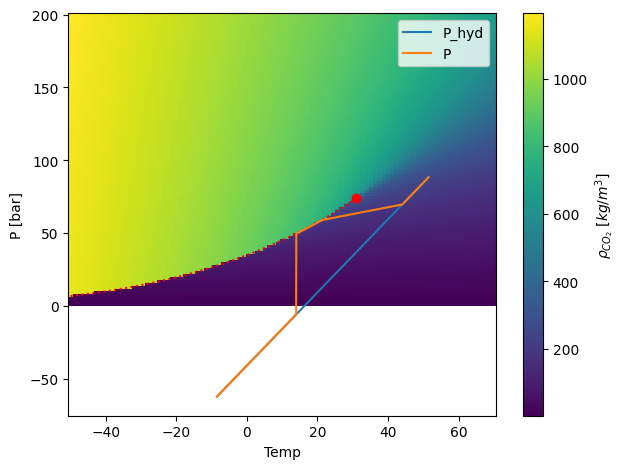

In [43]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')
